In [284]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
tickers = yf.Tickers('msft aapl goog')

# access each ticker using (example)
tickers.tickers['MSFT'].info
tickers.tickers['AAPL'].history(period="1mo")
tickers.tickers['GOOG'].actions

,Dividends,Stock Splits
Date,,
2014-03-27,0.0,2.002000
2015-04-27,0.0,1.002746
2022-07-18,0.0,20.000000


In [3]:
yf.download(tickers = "SPY AAPPPLL",  # list of tickers
            period = "1y",         # time period
            interval = "1d",       # trading interval
            ignore_tz = True,      # ignore timezone when aligning data from different exchanges?
            prepost = False )      # download pre/post market hours data?

[*********************100%***********************]  2 of 2 completed

1 Failed download:
- AAPPPLL: No data found, symbol may be delisted


Adj Close               Close                High              \
             AAPPPLL         SPY AAPPPLL         SPY AAPPPLL         SPY   
Date                                                                       
2022-02-11       NaN  433.428314     NaN  440.459991     NaN  451.609985   
2022-02-14       NaN  432.011322     NaN  439.019989     NaN  441.600006   
2022-02-15       NaN  438.978333     NaN  446.100006     NaN  446.279999   
2022-02-16       NaN  439.470337     NaN  446.600006     NaN  448.059998   
2022-02-17       NaN  430.082642     NaN  437.059998     NaN  446.570007   
...              ...         ...     ...         ...     ...         ...   
2023-02-06       NaN  409.829987     NaN  409.829987     NaN  411.290009   
2023-02-07       NaN  415.190002     NaN  415.190002     NaN  416.489990   
2023-02-08       NaN  410.649994     NaN  410.649994     NaN  414.529999   
2023-02-09       NaN  407.089996     NaN  407.089996     NaN  414.570007   
2023-02-10       NaN  408.040009     NaN  408.040009     NaN  408.440002   

               Low                Open              Volume             
           AAPPPLL         SPY AAPPPLL         SPY AAPPPLL        SPY  
Date                                                                   
2022-02-11     NaN  438.940002     NaN  449.410004     NaN  153214600  
2022-02-14     NaN  435.339996     NaN  439.920013     NaN  123006300  
2022-02-15     NaN  443.179993     NaN  443.730011     NaN   88482700  
2022-02-16     NaN  441.940002     NaN  443.929993     NaN   84863600  
2022-02-17     NaN  436.420013     NaN  443.220001     NaN  102259100  
...            ...         ...     ...         ...     ...        ...  
2023-02-06     NaN  408.100006     NaN  409.790009     NaN   60295300  
2023-02-07     NaN  407.570007     NaN  408.869995     NaN   90990700  
2023-02-08     NaN  409.929993     NaN  413.130005     NaN   76227500  
2023-02-09     NaN  405.809998     NaN  414.410004     NaN   78694900  
2023-02-10     NaN  405.010010     NaN  405.859985     NaN   70738000  

[251 rows x 12 columns]

In [290]:
class stock_data:
    import yfinance as yf
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import scipy.stats
    
    def __init__(self, ticker, start_date, end_date, risk_free_rate=0):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.risk_free_rate = risk_free_rate
        self.data = yf.download(self.ticker, self.start_date, self.end_date)
        self.data['Daily Return'] = self.data['Adj Close'].pct_change(1)
        self.sortino_ratio = None
        self.sharpe_ratio = None
        self.probabilistic_sharpe_ratio = None
        
        
    def info(self):
        print(f'Ticker: {self.ticker}, start_date: {self.start_date}, end_date:{self.end_date}')
    
    def _compute_sharpe_ratio(self):
        mean_return = self.data.dropna()['Daily Return'].mean()
        std = self.data.dropna()['Daily Return'].std()
        self.sharpe_ratio = (mean_return-self.risk_free_rate) / std
        del mean_return
        del std
    
        
    def get_sharpe_ratio(self, daily=True):
        if not self.sharpe_ratio:
            self._compute_sharpe_ratio()
        if daily:
            return self.sharpe_ratio
        else:
            return self.sharpe_ratio * (252 ** 0.5)
    
    def _compute_sortino_ratio(self, target=0):
        df = self.data.dropna()
        mean_return = df['Daily Return'].mean()
        downside = df[df['Daily Return'] < target]['Daily Return']
        std = downside.std()
        self.sortino_ratio = (mean_return-self.risk_free_rate) / std
        del df      
        
    def get_sortino_ratio(self, daily=True):
        if not self.sortino_ratio:
            self._compute_sortino_ratio()
        if daily:
            return self.sortino_ratio
        else:
            return self.sortino_ratio * (252 ** 0.5)
    
    def _compute_probabilistic_sharpe_ratio(self, benchmark=0):
        if not self.sortino_ratio:
            self._compute_sortino_ratio()
        import scipy.stats
        skew = scipy.stats.skew(self.data["Daily Return"].dropna())
        # Use fisher kurtosis
        kurtosis = scipy.stats.kurtosis(self.data["Daily Return"].dropna(), fisher=True)  
        n = len(self.data)
        std = ( (1 / (n-1)) * (1 + 0.5 * self.sortino_ratio**2 - skew * self.sortino_ratio + (kurtosis / 4) * self.sortino_ratio**2))**0.5
        ratio = (self.sortino_ratio - benchmark) / std
        self.probabilistic_sharpe_ratio = scipy.stats.norm.cdf(ratio)

    def get_probabalistic_sharpe_ratio(self, daily=True):
        if not self.probabilistic_sharpe_ratio:
            self._compute_probabilistic_sharpe_ratio()
        if daily:
            return self.probabilistic_sharpe_ratio
        else:
            return self.probabilistic_sharpe_ratio * (252 ** 0.5)

    
    def plot_daily_returns(self, kind='line', alpha=None):
        if kind == 'line':
            self.data.dropna()['Daily Return'].plot(kind=kind, label=self.ticker)
            plt.legend()
        elif kind =='hist':
            self.data.dropna()['Daily Return'].plot(kind=kind, bins=100, label=self.ticker, alpha=alpha)
            plt.legend()
        else:
            raise TypeError(f'Plot Kind of {kind} is not supported. Only line and hist kinds are supported')
    
    def plot_cumulative_daily_return_rate(self):
        cumul_return = (1 + self.data['Daily Return'].dropna()).cumprod() - 1
        (cumul_return * 100).plot()
        plt.ylabel("Cumulative Return as %")
        
    def plot_bollinger_bands(self, n=20, k=2):
        import matplotlib.pyplot as plt
        self.data['Adj Close'].plot()
        (self.data['Adj Close'].rolling(window=n).mean().dropna() + (k * self.data['Adj Close'].rolling(window=n).std().dropna())).plot(label='BOL_UPPER')
        (self.data['Adj Close'].rolling(window=n).mean().dropna() - (k * self.data['Adj Close'].rolling(window=n).std().dropna())).plot(label='BOL_LOWER')
        plt.legend()
            
class stock_comp:
    def __init__(self, tickers, start_date, end_date):
        from numpy import log
        self.tickers = tickers
        self.ticker_dict = {}
        self.mc_portfolio_returns = None
        self.mc_portfolio_vol = None
        self.mc_weights = None
        self.mc_sharpe_ratios = None
        
        for ticker in tickers:
            stock_data_obj_ = stock_data(ticker, start_date, end_date)
            if len(stock_data_obj_.data) != 0:
                self.ticker_dict[ticker] = stock_data_obj_
            else:
                print(f'Unable to retrieve stock data for ticker: {ticker}. Excluding this ticker from analysis')
                self.tickers.remove(ticker)

        
        self.n = len(self.tickers)
        self.bounds = tuple((0,1) for n in range(self.n))
        self.equal_weights = [(1 / self.n)] * self.n
        
        self.adj_close = pd.concat([df.data['Adj Close'] for df in self.ticker_dict.values()], axis=1)
        self.adj_close.columns = self.tickers
        
        self.rets = pd.concat([df.data['Daily Return'].dropna() for df in self.ticker_dict.values()], axis=1)
        self.rets.columns = self.tickers
        
        self.log_rets = log(self.adj_close/self.adj_close.shift(1))
        self.log_rets_cov = self.log_rets.cov()
        
    def get_ticker_dict(self):
        return self.ticker_dict
    
    def get_daily_returns(self):
        return self.rets
    
    def plot_daily_returns(self, kind='line', alpha=None):
        if kind == 'line':
            self.rets.plot(kind=kind)
        elif kind =='hist':
            self.rets.plot(kind=kind, bins=100, alpha=alpha)
            plt.legend()
        else:
            raise TypeError(f'Plot Kind of {kind} is not supported. Only line and hist kinds are supported')
    
    def _gen_random_weights(self):
        import numpy as np
        weights = np.random.random(self.n)
        return weights/ np.sum(weights)
    
    def _calculate_returns(self, weights, log_rets):
        from numpy import sum
        return sum(log_rets.mean()*weights) * 252 #Annualized Returns
    
    def _calculate_volatility(self, weights):
        from numpy import dot, sqrt
        annualized_cov = dot(self.log_rets_cov*252,weights)
        vol = dot(weights.transpose(),annualized_cov)
        return sqrt(vol)
    
    def _plot_bullet_graph(self, mc_portfolio_returns, mc_portfolio_vol, mc_sharpe_ratios):
        import matplotlib.pyplot as plt
        plt.figure(dpi=200,figsize=(10,5))
        plt.scatter(mc_portfolio_vol,mc_portfolio_returns,c=mc_sharpe_ratios)
        plt.ylabel('EXPECTED RETURNS')
        plt.xlabel('EXPECTED VOLATILITY')
        plt.colorbar(label="SHARPE RATIO")

        
    def run_monte_carlo_simulation(self, n_simulations=1000, efficient_frontier=False):
        from numpy import array
        self.mc_portfolio_returns = []
        self.mc_portfolio_vol = []
        self.mc_weights = []
        for sim in range(n_simulations):
            weights = self._gen_random_weights()
            self.mc_weights.append(weights)
            self.mc_portfolio_returns.append(self._calculate_returns(weights,self.log_rets))
            self.mc_portfolio_vol.append(self._calculate_volatility(weights))
            
        self.mc_sharpe_ratios = array(self.mc_portfolio_returns)/array(self.mc_portfolio_vol)
        self._plot_bullet_graph(self.mc_portfolio_returns, self.mc_portfolio_vol, self.mc_sharpe_ratios)
        
        if efficient_frontier:
            self._calculate_efficient_frontier()
            self._plot_efficient_frontier()
    
    def minimization_search_optimal_weights(self):
        from scipy.optimize import minimize
        from numpy import sum 
        def function_to_minimize(weights):
            # Note -1* because we need to minimize this
            # Its the same as maximizing the positive sharpe ratio
            return -1 * (self._calculate_returns(weights,self.log_rets)/self._calculate_volatility(weights))
        sum_constraint = ({'type': 'eq', 'fun': lambda weights: sum(weights)-1})
        self.minimization_search_results_ = minimize(fun=function_to_minimize,x0=self.equal_weights,bounds=self.bounds,constraints=sum_constraint)
        return self.minimization_search_results_
    
    def _calculate_efficient_frontier(self):
        from numpy import linspace, sum
        from scipy.optimize import minimize
        
        lower_bound_ret = round(min(self.mc_portfolio_returns), 2)
        upper_bound_ret = round(max(self.mc_portfolio_returns), 2)
        self.expected_returns_range_ = linspace(lower_bound_ret,upper_bound_ret,200)
        constraints = ({'type':'eq','fun': lambda weights: sum(weights)-1},
                       {'type':'eq','fun': lambda weights: self._calculate_returns(weights,self.log_rets) - possible_return})
        
        self.frontier_volatility_ = []
        
        for possible_return in self.expected_returns_range_:
            # function for return
            result = minimize(self._calculate_volatility,
                              self.equal_weights,
                              bounds=self.bounds,
                              constraints=constraints)
            
            self.frontier_volatility_.append(result['fun'])
        
    def _plot_efficient_frontier(self):
        from matplotlib.pyplot import plot
        plot(self.frontier_volatility_, self.expected_returns_range_, 'r--', linewidth=2)
    
    def get_optimal_porfolio_weight(self, volatility):
        pass
            
        

In [294]:
my_stock = stock_data('COST', '2017-01-01', '2021-01-01')

[*********************100%***********************]  1 of 1 completed


<Figure size 1500x300 with 0 Axes>

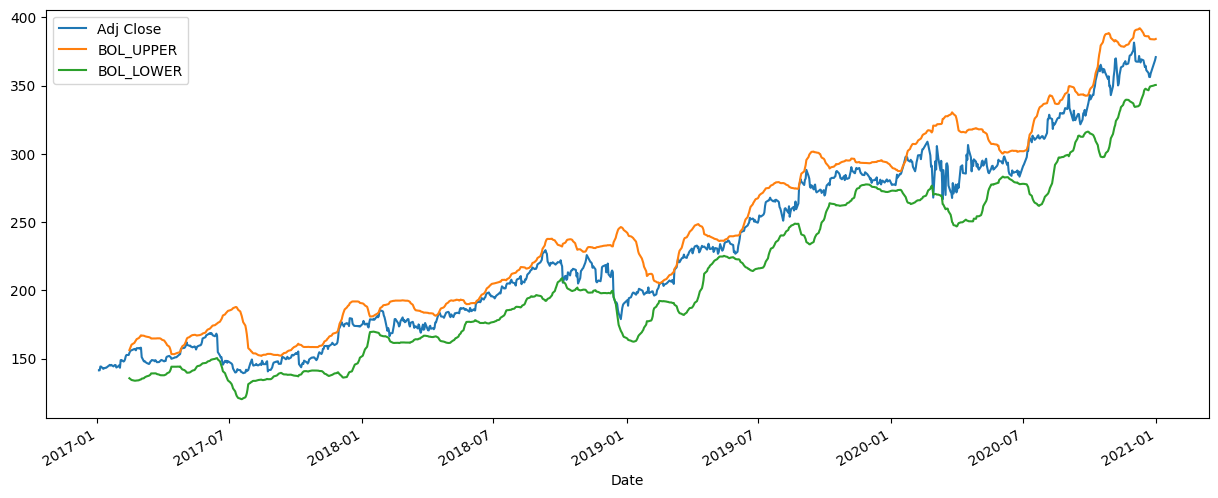

In [301]:
plt.figure(figsize=(15,6))
my_stock.plot_bollinger_bands(n=30, k=3)

In [279]:
tickers = ['AAPL', 'COST', 'MSFT']
start_date = '2017-01-01'
end_date = '2021-01-01'

comp = stock_comp(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


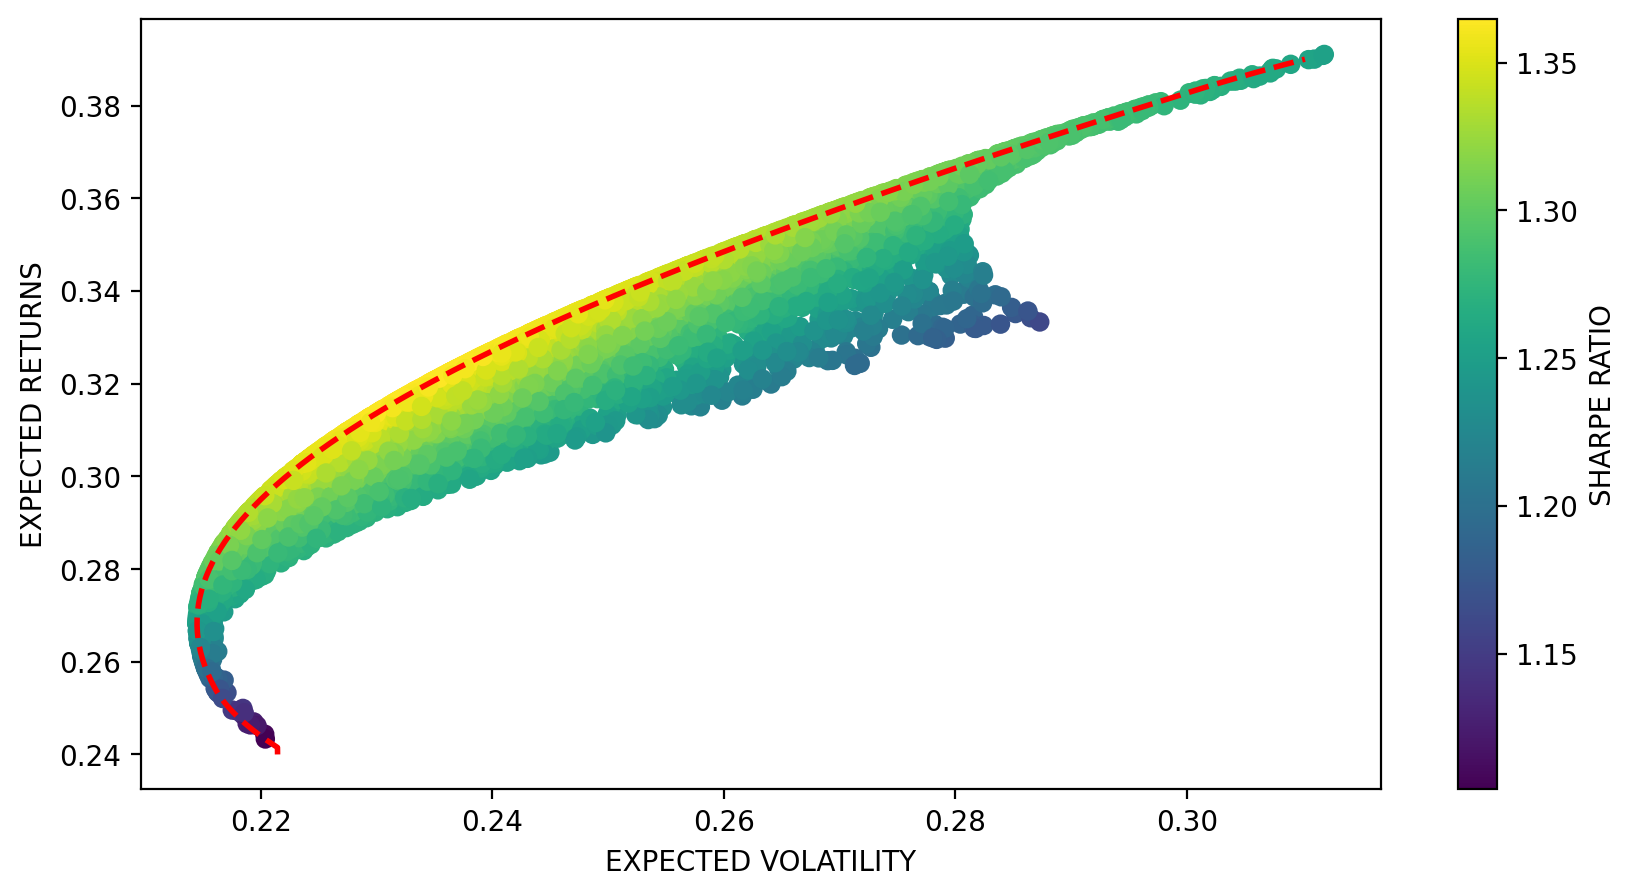

In [281]:
comp.run_monte_carlo_simulation(n_simulations = 10000, efficient_frontier=True)